In [2]:
import pandas as pd
import pip
pip.main(["install", "openpyxl"])
from IPython.display import display
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Requirement already satisfied: openpyxl in /Users/louiskrause/neuefische/Respiratory_Disease_Classification/.venv/lib/python3.9/site-packages (3.0.10)

Requirement already satisfied: et-xmlfile in /Users/louiskrause/neuefische/Respiratory_Disease_Classification/.venv/lib/python3.9/site-packages (from openpyxl) (1.1.0)

In [3]:
import os 
os.getcwd()

'/Users/louiskrause/neuefische/Respiratory_Disease_Classification/JNotebooks/Preprocessing'

### Load Diagnosis Annotations

In [4]:
filename = 'ICBHI_diagnosis.txt'
path = '../../data/' + filename

icbhi_anno = pd.read_csv(path, sep='\t', header=None, names=['id', 'diagnosis'])
icbhi_anno.diagnosis = icbhi_anno.diagnosis.str.lower()
print(icbhi_anno.shape)
icbhi_anno

(126, 2)


,id,diagnosis
0,101,urti
1,102,healthy
2,103,asthma
3,104,copd
4,105,urti
...,...,...
121,222,copd
122,223,copd
123,224,healthy
124,225,healthy


### ICBHI Load Soundfile Annotations

In [9]:
filename = 'ICBHI_train_test.txt'
path = '../../data/' + filename

ICBHI_sounds_annotations = pd.read_csv(path, sep = '\t', header = None, names=['filename', 'train_test'])
ICBHI_sounds_annotations['id'] = ICBHI_sounds_annotations.filename.str[:3].astype(int)
ICBHI_sounds_annotations.loc[919,'filename'] = '226_1b1_Pl_sc_LittC2SE'

In [10]:
ICBHI_sounds_annotations

,filename,train_test,id
0,101_1b1_Al_sc_Meditron,test,101
1,101_1b1_Pr_sc_Meditron,test,101
2,102_1b1_Ar_sc_Meditron,test,102
3,103_2b2_Ar_mc_LittC2SE,train,103
4,104_1b1_Al_sc_Litt3200,test,104
...,...,...,...
915,224_1b2_Al_sc_Meditron,test,224
916,225_1b1_Pl_sc_Meditron,test,225
917,226_1b1_Al_sc_Meditron,train,226
918,226_1b1_Ll_sc_Meditron,train,226


### Merge ICBHI files

In [7]:
ICBHI_sounds_annotations = ICBHI_sounds_annotations.merge(icbhi_anno, on='id')
ICBHI_sounds_annotations['filename'] = ICBHI_sounds_annotations['filename'] + '.wav'
columns_titles = ['id', 'diagnosis', 'train_test', 'filename']
ICBHI_sounds_annotations=ICBHI_sounds_annotations.reindex(columns=columns_titles)
ICBHI_sounds_annotations.id = 'i' + ICBHI_sounds_annotations.id.astype(str)
display(ICBHI_sounds_annotations.train_test.value_counts()/ICBHI_sounds_annotations.shape[0])
display(ICBHI_sounds_annotations)

train    0.58587
test     0.41413
Name: train_test, dtype: float64

,id,diagnosis,train_test,filename
0,i101,urti,test,101_1b1_Al_sc_Meditron.wav
1,i101,urti,test,101_1b1_Pr_sc_Meditron.wav
2,i102,healthy,test,102_1b1_Ar_sc_Meditron.wav
3,i103,asthma,train,103_2b2_Ar_mc_LittC2SE.wav
4,i104,copd,test,104_1b1_Al_sc_Litt3200.wav
...,...,...,...,...
915,i224,healthy,test,224_1b2_Al_sc_Meditron.wav
916,i225,healthy,test,225_1b1_Pl_sc_Meditron.wav
917,i226,pneumonia,train,226_1b1_Al_sc_Meditron.wav
918,i226,pneumonia,train,226_1b1_Ll_sc_Meditron.wav


In [13]:
os.getcwd()

'/Users/louiskrause/neuefische/Respiratory_Disease_Classification/JNotebooks/Preprocessing'

### Create Annotations for Fraiwan2021

In [15]:
# read annotations of fraiwan2021
filename = "Fraiwan_diagnosis.xlsx"
path = "../../data/" + filename
print(path)
fraiwan_anno = pd.read_excel(path)
fraiwan_anno = (
    fraiwan_anno["Diagnosis"]
    .reset_index()
    .rename({"index": "id", "Diagnosis": "diagnosis"}, axis=1)
    .dropna()
)

# let id start from 1
fraiwan_anno.id += 1
# replace string 'n' with 'health'
fraiwan_anno.diagnosis = fraiwan_anno.diagnosis.str.lower().str.replace(
    r"\bn\b", "healthy"
)


# replace string 'bron' with 'bronchitis'
fraiwan_anno.diagnosis = fraiwan_anno.diagnosis.str.replace(r"\bbron\b", "bronchitis")

display(fraiwan_anno.diagnosis.value_counts())

# read texfile of filenames from fraiwan2021
filename = "fraiwan_filenames.txt"
path = "../../data/" + filename
fraiwan_filenames = pd.read_csv(path, header=None, sep="\t", names=["filename"])

# get id from filename
fraiwan_filenames["id"] = (
    fraiwan_filenames.filename.str.findall("[\w]{2}(\d+)").str[0].astype(int)
)

# get frequency filter from filename
fraiwan_filenames["filter"] = fraiwan_filenames.filename.str.findall(
    "(\w{2})[\d]+"
).str[0]


fraiwan_sounds_annotations = fraiwan_filenames.merge(fraiwan_anno, on="id")

# drop rows with less frequent labels; min frequency of 3 since we are doin a train/test split by at least 66/33%
labels_drop = ["plueral effusion"]

# map to change labels
labels_map = {
    "asthma and lung fibrosis": "asthma",
    "heart failure + lung fibrosis ": "lung fibrosis",
    "heart failure + copd": "copd",
}
fraiwan_sounds_annotations["diagnosis"] = fraiwan_sounds_annotations[
    "diagnosis"
].replace(labels_map)

# drop rows with labels
fraiwan_sounds_annotations = fraiwan_sounds_annotations[
    ~fraiwan_sounds_annotations.diagnosis.isin(labels_drop)
]

# combine two columns to make stratified train test split on that
fraiwan_sounds_annotations["diagnosis_filter"] = fraiwan_sounds_annotations[
    "diagnosis"
].astype(str) + fraiwan_sounds_annotations["filter"].astype(str)


display(
    fraiwan_sounds_annotations["diagnosis"].value_counts().tail(19)
)  # since we are doin a train/test split by at least 66/33%

# split dataset into train and test split 66% / 33%
X_train, X_test = train_test_split(
    fraiwan_sounds_annotations,
    test_size=1 / 3,
    stratify=fraiwan_sounds_annotations.diagnosis_filter,
)

# add train/test column
fraiwan_sounds_annotations["train_test"] = np.where(
    fraiwan_sounds_annotations.index.isin(X_train.index), "train", "test"
)

# change ids to identify from which dataset the row is
fraiwan_sounds_annotations.id = "f" + fraiwan_sounds_annotations.id.astype(str)

fraiwan_sounds_annotations

../../data/Fraiwan_diagnosis.xlsx


/var/folders/5z/wvdyq1hd6t7601xb2n5v_m880000gn/T/ipykernel_4466/3957327535.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  fraiwan_anno.diagnosis = fraiwan_anno.diagnosis.str.lower().str.replace(
/var/folders/5z/wvdyq1hd6t7601xb2n5v_m880000gn/T/ipykernel_4466/3957327535.py:22: FutureWarning: The default value of regex will change from True to False in a future version.
  fraiwan_anno.diagnosis = fraiwan_anno.diagnosis.str.replace(r"\bbron\b", "bronchitis")


healthy                           35
asthma                            32
heart failure                     18
copd                               9
pneumonia                          5
lung fibrosis                      4
bronchitis                         3
heart failure + copd               2
plueral effusion                   2
heart failure + lung fibrosis      1
asthma and lung fibrosis           1
Name: diagnosis, dtype: int64

healthy          105
asthma            99
heart failure     54
copd              33
lung fibrosis     15
pneumonia         15
bronchitis         9
Name: diagnosis, dtype: int64

,filename,id,filter,diagnosis,diagnosis_filter,train_test
0,"BP1_Asthma,I E W,P L L,70,M.wav",f1,BP,asthma,asthmaBP,train
1,"DP1_Asthma,I E W,P L L,70,M.wav",f1,DP,asthma,asthmaDP,train
2,"EP1_Asthma,I E W,P L L,70,M.wav",f1,EP,asthma,asthmaEP,test
3,"BP2_Asthma,E W,P L L R,52,F.wav",f2,BP,asthma,asthmaBP,train
4,"DP2_Asthma,E W,P L L R,52,F.wav",f2,DP,asthma,asthmaDP,test
...,...,...,...,...,...,...
331,"DP111_COPD,E W,P R L ,51,M.wav",f111,DP,copd,copdDP,train
332,"EP111_COPD,E W,P R L ,51,M.wav",f111,EP,copd,copdEP,test
333,"BP112_N,N,P L M,30,M.wav",f112,BP,healthy,healthyBP,train
334,"DP112_N,N,P L M,30,M.wav",f112,DP,healthy,healthyDP,train


### Merge Dataframes

In [16]:
sound_annotations = pd.concat([ICBHI_sounds_annotations, fraiwan_sounds_annotations]).drop(columns=['filter', 'diagnosis_filter']).reset_index(drop = True)
sound_annotations.train_test.value_counts()


#create new label column for healthy/unhealthy
sound_annotations['is_healthy'] = np.where(sound_annotations.diagnosis == 'healthy', 1, 0)
sound_annotations

,id,diagnosis,train_test,filename,is_healthy
0,i101,urti,test,101_1b1_Al_sc_Meditron.wav,0
1,i101,urti,test,101_1b1_Pr_sc_Meditron.wav,0
2,i102,healthy,test,102_1b1_Ar_sc_Meditron.wav,1
3,i103,asthma,train,103_2b2_Ar_mc_LittC2SE.wav,0
4,i104,copd,test,104_1b1_Al_sc_Litt3200.wav,0
...,...,...,...,...,...
1245,f111,copd,train,"DP111_COPD,E W,P R L ,51,M.wav",0
1246,f111,copd,test,"EP111_COPD,E W,P R L ,51,M.wav",0
1247,f112,healthy,train,"BP112_N,N,P L M,30,M.wav",1
1248,f112,healthy,train,"DP112_N,N,P L M,30,M.wav",1


,diagnosis_fraiwan,diagnosis_icbhi
copd,33,793
healthy,105,35
asthma,99,1
heart failure,54,0
pneumonia,15,37
urti,0,23
bronchiectasis,0,16
lung fibrosis,15,0
bronchiolitis,0,13
bronchitis,9,0


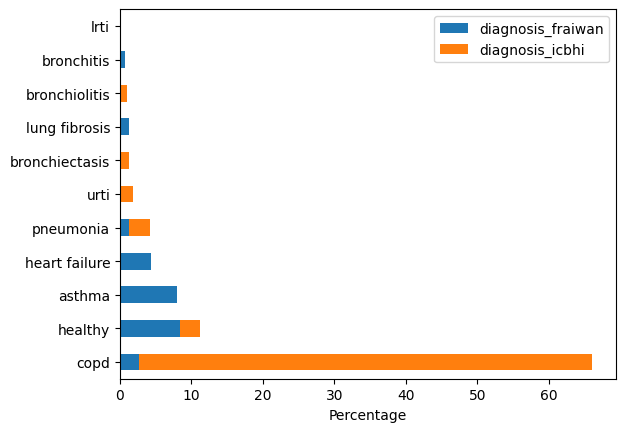

In [17]:
Labels_fraiwan = pd.DataFrame(fraiwan_sounds_annotations.diagnosis.value_counts())
Labels_icbhi = pd.DataFrame(ICBHI_sounds_annotations.diagnosis.value_counts())
#display(Labels_fraiwan)
#display(Labels_icbhi)
Labels = pd.merge(Labels_fraiwan, Labels_icbhi, how = 'outer', left_index=True, right_index=True, suffixes=('_fraiwan', '_icbhi')).fillna(0).astype(int)
total = Labels.to_numpy().sum()
Labels['total'] = Labels.sum(axis = 1)
Labels = Labels.sort_values(by = 'total', ascending=False).drop('total', axis = 1)
display(Labels)
Percentages = 100 * Labels / total
Percentages.plot(kind = 'barh', stacked = True)
plt.xlabel('Percentage')
plt.show()

In [22]:
print('distribution of unhealthy to healthy samples in %')
sound_annotations.is_healthy.value_counts() / sound_annotations.shape[0] * 100 

distribution of unhealthy to healthy samples in %


0    88.8
1    11.2
Name: is_healthy, dtype: float64

## Save new Target csv

In [24]:
path = '../../data/'
filename = 'annotations.csv'
path = path + filename
sound_annotations.to_csv(path)